In [1]:
import gzip
import struct
import numpy as np
import matplotlib.pyplot as plt

def read_gz(filename):
    with gzip.open(filename) as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        print("Found datastructure of shape", shape)
        return np.fromstring(f.read(), dtype=np.uint8).reshape(shape)

def plot_mnist(images, labels):
    N = len(labels)
    fig, ax = plt.subplots(ncols=N, figsize=(2*N, 2))
    fig.suptitle("Examples from MNIST dataset")
    for i in range(N):
        ax[i].imshow(images[i])
        ax[i].set_title(str(labels[i]))
    plt.show()

#pwd = "/home/alyosha/Downloads/mnist_data/"
pwd = "/home/aleksejs/Downloads/mnist_data/"
train_images = read_gz(pwd + "train-images-idx3-ubyte.gz")
train_labels = read_gz(pwd + "train-labels-idx1-ubyte.gz")
test_images = read_gz(pwd + "t10k-images-idx3-ubyte.gz")
test_labels = read_gz(pwd + "t10k-labels-idx1-ubyte.gz")

select_images = [0,1, 15, 138, 2000]
plot_mnist(train_images[select_images], train_labels[select_images])

Found datastructure of shape (60000, 28, 28)
Found datastructure of shape (60000,)
Found datastructure of shape (10000, 28, 28)
Found datastructure of shape (10000,)


/opt/anaconda3/envs/py36qt5/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # This is added back by InteractiveShellApp.init_path()


In [22]:
# Some nonlinear functions
sig       = lambda x: 1 / (1 + np.exp(-x))
relu      = lambda x: x*(x > 0)
leakyrelu = lambda x: x*((x > 0) + 0.01*(x < 0))

# And their derivatives
sigprim       = lambda x: 0.5 / (1 + np.cosh(x))
reluprim      = lambda x: (x > 0).astype(float)
leakyreluprim = lambda x: (x > 0) + 0.01*(x < 0)

# Convert labels to array of ones and zeos
def label2arr(x, N):
    arr = np.zeros(N)
    arr[x] = 1
    return arr

# Compute accuracy - how frequently the largest predicted number coincides with the true label
def computeAccuracy(yTrue1D, yPredicted2D):
    yPredicted1D = np.array([np.argmax(out) for out in yPredicted2D])
    return np.sum(yPredicted1D == yTrue1D) / yTrue1D.shape[0]

# Minibatch training algorithm
def trainTestNetwork(netClass, netParam, xTrain, yTrain, xTest, yTest, nY, nMini=32, nEpoch=100, nTimesSample=20):
    nTrialsTrain = xTrain.shape[0]
    nTrialsTest  = xTest.shape[0]
    nFeatures = np.prod(xTrain.shape[1:])
    
    # Convert data to format compatible with network [Trials x Features]
    xTrain2D  = xTrain.reshape(nTrialsTrain, nFeatures)
    xTest2D   = xTest.reshape(nTrialsTest, nFeatures)
    yTrain2D = np.array([label2arr(y, nY) for y in yTrain])
    yTest2D  = np.array([label2arr(y, nY) for y in yTest])
    
    # Initialize network
    netParam['nIn']  = nFeatures
    netParam['nOut'] = nY
    net = netClass(netParam)

    # Train network, trackign accuracy
    lossProgress = []
    trainAccuracy = np.zeros(nEpoch)
    testAccuracy  = np.zeros(nEpoch)
    nMiniBatches = int(np.ceil(nTrialsTrain / nMini))
    
    for iEpoch in range(nEpoch):
        eta = (0.01 if iEpoch < 20 else 0.001) * netParam['etaPref']
        #eta = 0.01 if iEpoch < 20 else 0.001
        for iMiniBatch in range(nMiniBatches):
            idxl = nMini * iMiniBatch
            idxr = nMini * (iMiniBatch + 1)
            
            lossProgress += [net.step(xTrain2D[idxl:idxr], yTrain2D[idxl:idxr], eta)]
        
        trainAccuracy[iEpoch] = computeAccuracy(yTrain, net.predict(xTrain2D))
        testAccuracy[iEpoch] = computeAccuracy(yTest, net.predict(xTest2D))
        print("Did epoch", iEpoch, 
              "::: Train accuracy", np.round(trainAccuracy[iEpoch], 2),
              "::: Test accuracy", np.round(testAccuracy[iEpoch], 2))
        
    # Plot results
    fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
    ax[0].set_title("Loss function")
    ax[1].set_title("Accuracy")
    ax[0].set_xlabel("miniBatch index")
    ax[1].set_xlabel("Epoch")
    ax[0].plot(lossProgress)
    ax[1].plot(trainAccuracy, label='train')
    ax[1].plot(testAccuracy, label='test')
    ax[1].legend()
    plt.show()

# Shallow Neural Network

Have labelled data $x_{ij}$ with labels $y_{ik}$, where
* $i\in[1..N_{data}]$ is the number of datapoints
* $j\in[1..N_{in}]$ is the number of input features
* $k\in[1..N_{out}]$ is the number of label features

A shallow NN is defined by a linear operation, followed by a nonlinear operation.

$$
\begin{eqnarray}
l_k       &=& \sum_j W_{kj} x_j + b_k\\
\hat{y}_k &=& f(l_k)
\end{eqnarray}
$$

NN is optimized to perform well on average for all datapoints. This is described by a loss function

$$L^2 = \sum_{ik} L_{ik}^2 = \sum_{ik} (\hat{y}_{ik} - y_{ik})^2$$

Since it is a nonlinear function, it can't be minimized analytically. Instead, a gradient descent method can be applied to minimize it gradually

$$
\begin{eqnarray}
\tau \dot{W}_{uv}
&=& -\frac{1}{2}\frac{\partial L^2}{\partial W_{uv}}
= -\sum_{ik} L_{ik} f'_{ik} \sum_j \delta_{ku} \delta_{jv} x_{ij}
= -\sum_{i} L_{iu} f'_{iu} x_{iv}
&= \sum_{i} (y_{iu} - f_{iu}) f'_{iu} x_{iv} \\
\tau \dot{b}_{u}
&=& -\frac{1}{2}\frac{\partial L^2}{\partial b_{u}}
= ...
&= \sum_{i} (y_{iu} - f_{iu}) f'_{iu}
\end{eqnarray}
$$

So the algorithm is:
1. Init $W$ and $b$ with random numbers
2. Compute $f$ and $f'$ for each input
3. Thus, compute gradients for $W$ and $b$
4. Change $W$ and $b$ in the optimal direction
5. Check if have converged, if not, repeat from 1.

In [23]:
class ShallowNet:
    def __init__(self, p):
        self.nonlinFunc     = p['nonlinFunc']
        self.nonlinPrimFunc = p['nonlinPrimFunc']
        self.b = np.random.normal(0, 1, p['nOut'])
        self.W = np.random.normal(0, 1, (p['nOut'], p['nIn']))
        
    # Linear part of the predictor
    def lin(self, x, W, b):
        return x.dot(W.T) + b  # Flipped order to do vector broadcasting
        
    # Dimensions of x are [nTrial, nFeature]
    def predict(self, x):
        lin = self.lin(x, self.W, self.b)
        return self.nonlinFunc(lin)
    
    def step(self, x, y, eta):
        lin = self.lin(x, self.W, self.b)
        f = self.nonlinFunc(lin)      # Nonlinear function
        g = self.nonlinPrimFunc(lin)  # It's derivative
        
        err = y - f
        errg = err*g
        self.b += eta * np.sum(errg, axis=0)
        self.W += eta * errg.T.dot(x)
        return np.mean(np.linalg.norm(err, axis=1))

/opt/anaconda3/envs/py36qt5/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/opt/anaconda3/envs/py36qt5/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in cosh
  import sys


Did epoch 0 ::: Train accuracy 0.18 ::: Test accuracy 0.19
Did epoch 1 ::: Train accuracy 0.2 ::: Test accuracy 0.2
Did epoch 2 ::: Train accuracy 0.23 ::: Test accuracy 0.23
Did epoch 3 ::: Train accuracy 0.26 ::: Test accuracy 0.27
Did epoch 4 ::: Train accuracy 0.26 ::: Test accuracy 0.26
Did epoch 5 ::: Train accuracy 0.29 ::: Test accuracy 0.29
Did epoch 6 ::: Train accuracy 0.27 ::: Test accuracy 0.28
Did epoch 7 ::: Train accuracy 0.31 ::: Test accuracy 0.31
Did epoch 8 ::: Train accuracy 0.3 ::: Test accuracy 0.31
Did epoch 9 ::: Train accuracy 0.29 ::: Test accuracy 0.29


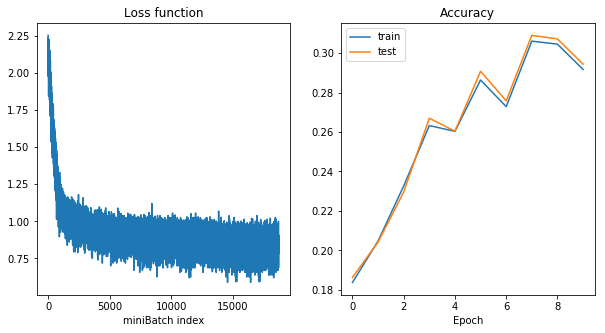

In [29]:
param = {
    'etaPref'        : 0.1,
    'nonlinFunc'     : #sig,
    'nonlinPrimFunc' : #sigprim
}

trainTestNetwork(ShallowNet, param, train_images, train_labels, test_images, test_labels, 10, nEpoch=10)

# Deep Neural Network

Premise is the same, but now the network consists of several layers of weights and biases. There are now $M-1$ hidden layers $h$, and $M$ sets of weights and biases.

$$
\begin{eqnarray}
\hat{y}_k &=& f(l^M_k) \\
h^{n}_k   &=& f(l^{n-1}_k)\\
l^n_k     &=& \sum_j W^n_{kj} h^{n-1}_j + b^n_k \\
l^1_k     &=& \sum_j W^1_{kj} x_j + b^1_k
\end{eqnarray}
$$

For simplicity, define $g(x) = f'(x)$.
Computing derivatives of the loss function with respect to an abstract parameter $z$ we get

$$
\begin{eqnarray}
\frac{\partial L^2}{\partial z}
&=& \sum_{ik} L_{ik} g(l^M_{ik}) \sum_j W^M_{kj} \frac{\partial h_{ij}^{M-1}}{\partial z} \\
\frac{\partial h_{ij}^n}{\partial z}
&=& \sum_{k} g(l^n_{ik}) \sum_j W^n_{kj} \frac{\partial h_{ij}^{n-1}}{\partial z}
\end{eqnarray}
$$

Thus, the derivative with respect to particular weights and biases are (using Einstein summation notation)

$$
\begin{eqnarray}
\frac{\partial L^2}{\partial W^n_{uv}}
&=& 2 L_{ia} g^M_{ia} W^M_{ab} \cdot g^{M-1}_{ib} W^{M-1}_{bc} \cdot ... \cdot g^{n+1}_{if} W^{n+1}_{fu} \cdot g^{n}_{iu} h^{n-1}_{iv}\\
\frac{\partial L^2}{\partial b^n_{u}}
&=& 2 L_{ia} g^M_{ia} W^M_{ab} \cdot g^{M-1}_{ib} W^{M-1}_{bc} \cdot ... \cdot g^{n+1}_{if} W^{n+1}_{fu} \cdot g^{n}_{iu}
\end{eqnarray}
$$

To simplify the expression, let us define a backpropagated error intermediate variable for each layer

$$
\begin{eqnarray}
\epsilon^{M}_{ia} &=& -L_{ia} \\
\epsilon^n_{ia}   &=& \epsilon^{n+1}_{ib} g^{n+1}_{ib} W^{n+1}_{ba} \\
\end{eqnarray}
$$

Rewriting the expressions for derivatives we get

$$
\begin{eqnarray}
\tau \dot{W}^n_{uv}
&=& -\frac{1}{2}\frac{\partial L^2}{\partial W^n_{uv}}
&= \epsilon^{n}_{iu} g^{n}_{iu} h^{n-1}_{iv} \\
\tau \dot{b}^n_{u}
&=& -\frac{1}{2} \frac{\partial L^2}{\partial b^n_{u}}
&= \epsilon^{n}_{iu} g^{n}_{iu}
\end{eqnarray}
$$

The forwards propagation algorithm is:
1. Input $x_i$ for some minibatch of subset of datapoints
2. Progressively compute $h^n_i$ until $\hat{y}_i$ is computed
3. Compute loss function $L_i$, note performance

So the algorithm is:
1. Compute $g$ for this level
2. Compute $\epsilon$ for this level
3. Compute gradients for params at this level
4. Proceed to deeper level

In [69]:
class DeepNet:
    def __init__(self, p):
        nNodeAll = [p['nIn']] + p['nHid'] + [p['nOut']]
        self.nLayer = len(nNodeAll)
        
        self.b = []
        self.W = []
        for i in range(1, self.nLayer):
            self.b += [np.random.normal(0,1, nNodeAll[i])]
            self.W += [np.random.normal(0,1, (nNodeAll[i], nNodeAll[i-1]))]
        
    # Linear part of the feedforward step
    def lin(self, x, W, b):
        return x.dot(W.T) + b  # Flipped order to do vector broadcasting
        
    # Dimensions of x are [nTrial, nFeature]
    def predict(self, x):
        hThis = x
        for b, W in zip(self.b, self.W):
            l = self.lin(hThis, W, b)
            hThis = sig(l)
        return hThis
    
    # Make single gradient descent step, given a bunch of data and associated labels
    def step(self, x, y, eta):
        # Forwards pass
        h = [x]  # Function values for different layers
        g = [1]  # Derivative function values for different layers
        for b, W in zip(self.b, self.W):
            l = self.lin(h[-1], W, b)
            h += [sig(l)]
            g += [sigprim(l)]
            
        # Backwards pass
        err = [1] * (self.nLayer-2) + [y - h[-1]]
        for iLayer in range(self.nLayer-2, 0, -1):
            #print(iLayer, err[iLayer].shape, h[iLayer].shape, g[iLayer].shape)
            errg = err[iLayer] * g[iLayer+1]
            err[iLayer-1] = errg.dot(self.W[iLayer])
            self.b[iLayer] += eta * np.sum(errg, axis=0)
            self.W[iLayer] += eta * errg.T.dot(h[iLayer])
            
        return np.mean(np.linalg.norm(err[-1], axis=1))

/opt/anaconda3/envs/py36qt5/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/envs/py36qt5/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in cosh
  


Did epoch 0 ::: Train accuracy 0.34 ::: Test accuracy 0.35
Did epoch 1 ::: Train accuracy 0.46 ::: Test accuracy 0.46
Did epoch 2 ::: Train accuracy 0.49 ::: Test accuracy 0.49
Did epoch 3 ::: Train accuracy 0.5 ::: Test accuracy 0.5
Did epoch 4 ::: Train accuracy 0.51 ::: Test accuracy 0.5
Did epoch 5 ::: Train accuracy 0.51 ::: Test accuracy 0.51
Did epoch 6 ::: Train accuracy 0.53 ::: Test accuracy 0.52
Did epoch 7 ::: Train accuracy 0.53 ::: Test accuracy 0.53
Did epoch 8 ::: Train accuracy 0.54 ::: Test accuracy 0.54
Did epoch 9 ::: Train accuracy 0.54 ::: Test accuracy 0.55
Did epoch 10 ::: Train accuracy 0.55 ::: Test accuracy 0.56
Did epoch 11 ::: Train accuracy 0.56 ::: Test accuracy 0.56
Did epoch 12 ::: Train accuracy 0.56 ::: Test accuracy 0.56
Did epoch 13 ::: Train accuracy 0.56 ::: Test accuracy 0.56
Did epoch 14 ::: Train accuracy 0.56 ::: Test accuracy 0.56
Did epoch 15 ::: Train accuracy 0.56 ::: Test accuracy 0.56
Did epoch 16 ::: Train accuracy 0.56 ::: Test accurac

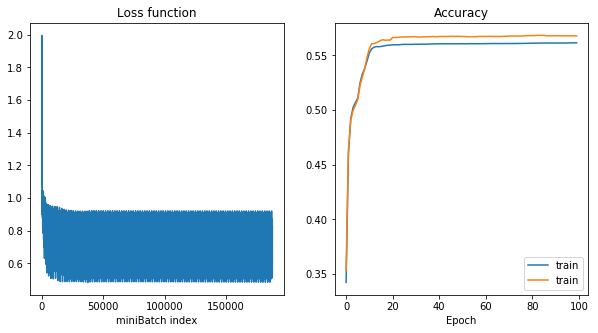

In [70]:
param1Hid = {'nHid' : [30]} # One hidden layer
trainTestNetwork(DeepNet, param1Hid, train_images, train_labels, test_images, test_labels, 10, nEpoch=100)

/opt/anaconda3/envs/py36qt5/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/envs/py36qt5/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in cosh
  


Did epoch 0 ::: Train accuracy 0.36 ::: Test accuracy 0.37
Did epoch 1 ::: Train accuracy 0.49 ::: Test accuracy 0.5
Did epoch 2 ::: Train accuracy 0.56 ::: Test accuracy 0.57
Did epoch 3 ::: Train accuracy 0.6 ::: Test accuracy 0.61
Did epoch 4 ::: Train accuracy 0.63 ::: Test accuracy 0.64
Did epoch 5 ::: Train accuracy 0.64 ::: Test accuracy 0.65
Did epoch 6 ::: Train accuracy 0.66 ::: Test accuracy 0.66
Did epoch 7 ::: Train accuracy 0.66 ::: Test accuracy 0.67
Did epoch 8 ::: Train accuracy 0.67 ::: Test accuracy 0.67
Did epoch 9 ::: Train accuracy 0.67 ::: Test accuracy 0.68
Did epoch 10 ::: Train accuracy 0.68 ::: Test accuracy 0.68
Did epoch 11 ::: Train accuracy 0.68 ::: Test accuracy 0.68
Did epoch 12 ::: Train accuracy 0.68 ::: Test accuracy 0.69
Did epoch 13 ::: Train accuracy 0.69 ::: Test accuracy 0.69
Did epoch 14 ::: Train accuracy 0.69 ::: Test accuracy 0.69
Did epoch 15 ::: Train accuracy 0.69 ::: Test accuracy 0.69
Did epoch 16 ::: Train accuracy 0.69 ::: Test accura

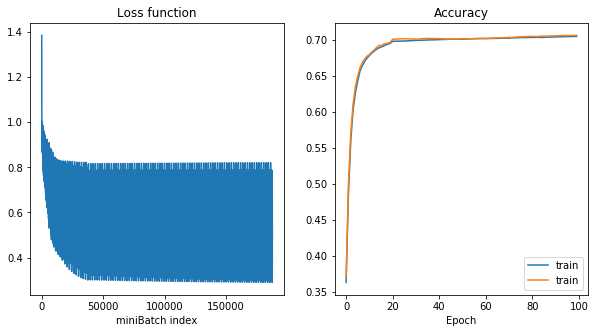

In [71]:
param1Hid = {'nHid' : [50, 20]} # Two hidden layers
trainTestNetwork(DeepNet, param1Hid, train_images, train_labels, test_images, test_labels, 10, nEpoch=100)

# Feedback Alignment

Lillicrap et. al claim that backprop works if the feedback is mediated by a set of completely random matrices. There was another paper however, that claimed that at least the signs of the matrix elements should match. In the context of the previous chapter, we define random matrices $R^n$ of the same shape as the transpose of the corresponding feedforwards matrices $W^n$, and re-define the backpropagated error as

$$\epsilon^n_{ia} = \epsilon^{n+1}_{ib} g^{n+1}_{ib} R^{n+1}_{ba}$$

**TODO**:
1. Check if we understand the statement correctly
2. What was the other paper?
3. Any statement about biases? Are they random or same as in original?

In [4]:
class LillicrapDeepNet:
    def __init__(self, p):
        nNodeAll = [p['nIn']] + p['nHid'] + [p['nOut']]
        self.nLayer = len(nNodeAll)
        
        self.b = []
        self.W = []
        self.R = []
        for i in range(1, self.nLayer):
            self.b += [np.random.normal(0,1, nNodeAll[i])]
            self.W += [np.random.normal(0,1, (nNodeAll[i], nNodeAll[i-1]))]
            self.R += [np.random.normal(0,1, (nNodeAll[i], nNodeAll[i-1]))]
        
    # Linear part of the feedforward step
    def lin(self, x, W, b):
        return x.dot(W.T) + b  # Flipped order to do vector broadcasting
        
    # Dimensions of x are [nTrial, nFeature]
    def predict(self, x):
        hThis = x
        for b, W in zip(self.b, self.W):
            l = self.lin(hThis, W, b)
            hThis = sig(l)
        return hThis
    
    # Make single gradient descent step, given a bunch of data and associated labels
    def step(self, x, y, eta):
        # Forwards pass
        h = [x]  # Function values for different layers
        g = [1]  # Derivative function values for different layers
        for b, W in zip(self.b, self.W):
            l = self.lin(h[-1], W, b)
            h += [sig(l)]
            g += [sigprim(l)]
            
        # Backwards pass
        err = [1] * (self.nLayer-2) + [y - h[-1]]
        for iLayer in range(self.nLayer-2, 0, -1):
            #print(iLayer, err[iLayer].shape, h[iLayer].shape, g[iLayer].shape)
            errg = err[iLayer] * g[iLayer+1]
            err[iLayer-1] = errg.dot(self.R[iLayer])
            self.b[iLayer] += eta * np.sum(errg, axis=0)
            self.W[iLayer] += eta * errg.T.dot(h[iLayer])
            
        return np.mean(np.linalg.norm(err[-1], axis=1))

/opt/anaconda3/envs/py36qt5/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/envs/py36qt5/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in cosh
  import sys


Did epoch 0 ::: Train accuracy 0.23 ::: Test accuracy 0.24
Did epoch 1 ::: Train accuracy 0.37 ::: Test accuracy 0.36
Did epoch 2 ::: Train accuracy 0.42 ::: Test accuracy 0.41
Did epoch 3 ::: Train accuracy 0.43 ::: Test accuracy 0.43
Did epoch 4 ::: Train accuracy 0.45 ::: Test accuracy 0.45
Did epoch 5 ::: Train accuracy 0.46 ::: Test accuracy 0.46
Did epoch 6 ::: Train accuracy 0.47 ::: Test accuracy 0.47
Did epoch 7 ::: Train accuracy 0.49 ::: Test accuracy 0.48
Did epoch 8 ::: Train accuracy 0.49 ::: Test accuracy 0.49
Did epoch 9 ::: Train accuracy 0.49 ::: Test accuracy 0.49
Did epoch 10 ::: Train accuracy 0.49 ::: Test accuracy 0.49
Did epoch 11 ::: Train accuracy 0.49 ::: Test accuracy 0.5
Did epoch 12 ::: Train accuracy 0.5 ::: Test accuracy 0.5
Did epoch 13 ::: Train accuracy 0.53 ::: Test accuracy 0.52
Did epoch 14 ::: Train accuracy 0.54 ::: Test accuracy 0.53
Did epoch 15 ::: Train accuracy 0.56 ::: Test accuracy 0.55
Did epoch 16 ::: Train accuracy 0.56 ::: Test accurac

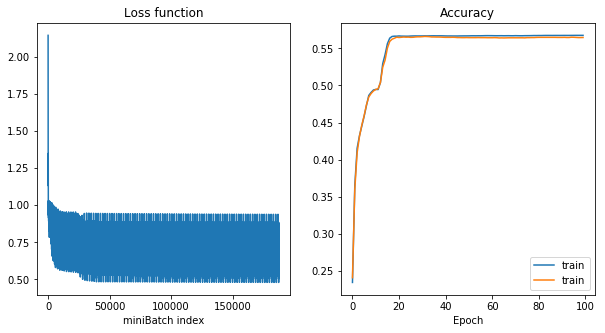

In [5]:
param1Hid = {'nHid' : [30]} # One hidden layer
trainTestNetwork(LillicrapDeepNet, param1Hid, train_images, train_labels, test_images, test_labels, 10, nEpoch=100)

/opt/anaconda3/envs/py36qt5/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/envs/py36qt5/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in cosh
  import sys


Did epoch 0 ::: Train accuracy 0.29 ::: Test accuracy 0.29
Did epoch 1 ::: Train accuracy 0.46 ::: Test accuracy 0.48
Did epoch 2 ::: Train accuracy 0.55 ::: Test accuracy 0.56
Did epoch 3 ::: Train accuracy 0.58 ::: Test accuracy 0.6
Did epoch 4 ::: Train accuracy 0.6 ::: Test accuracy 0.62
Did epoch 5 ::: Train accuracy 0.62 ::: Test accuracy 0.63
Did epoch 6 ::: Train accuracy 0.63 ::: Test accuracy 0.64
Did epoch 7 ::: Train accuracy 0.63 ::: Test accuracy 0.65
Did epoch 8 ::: Train accuracy 0.64 ::: Test accuracy 0.65
Did epoch 9 ::: Train accuracy 0.65 ::: Test accuracy 0.66
Did epoch 10 ::: Train accuracy 0.65 ::: Test accuracy 0.66
Did epoch 11 ::: Train accuracy 0.66 ::: Test accuracy 0.67
Did epoch 12 ::: Train accuracy 0.66 ::: Test accuracy 0.67
Did epoch 13 ::: Train accuracy 0.66 ::: Test accuracy 0.67
Did epoch 14 ::: Train accuracy 0.66 ::: Test accuracy 0.68
Did epoch 15 ::: Train accuracy 0.66 ::: Test accuracy 0.68
Did epoch 16 ::: Train accuracy 0.67 ::: Test accura

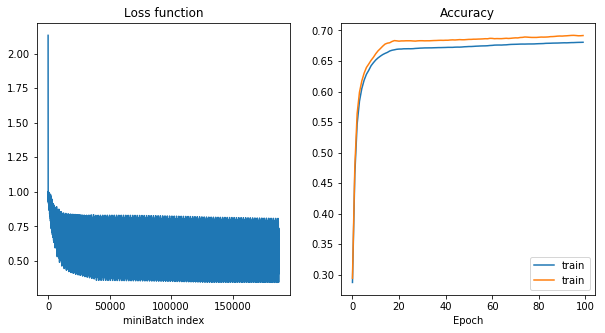

In [6]:
param1Hid = {'nHid' : [50, 20]} # Two hidden layers
trainTestNetwork(LillicrapDeepNet, param1Hid, train_images, train_labels, test_images, test_labels, 10, nEpoch=100)